In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for calling in data
from astropy.io import fits
import h5py
from astropy import units as u

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

In [2]:
m3f = h5py.File('OAP3.h5', 'r')
list(m3f.keys())

['4D', 'measurement0']

In [3]:
# check the attributes
list(m3f['4D'].attrs)

['_4Sight_build_date',
 '_4Sight_build_num',
 '_4Sight_version',
 'date',
 'file_version',
 'nummeas',
 'schema_url']

In [4]:
m3f['4D'].attrs['schema_url']
# The website doesn't work!!!!

b'http://www.4dtechnology.com/techsupport/dataformat.html'

Check the attributes in the other key

In [5]:
attr = m3f['measurement0'].attrs
attr_list = list(attr)
for j in range(0, len(attr_list)):
    attr_name = attr_list[j]
    print('{0}: {1}'.format(attr_name, attr[attr_name]))

Chucked: 0
averages: b'1'
camera_settings: b'g:4 e:0.07'
date: b'Thu Jul 22 16:39:14 2021'
focus_position: b'N/A'
guid: b'{6B25E697-DAD4-44D8-9F36-E44F96BE787B}'
head_serial: b'B243'
measurement_mode: b'Dynamic - (Pix-3x3)'
optical_zoom: b'1.00'
pathmatch_distance: b'N/A'
sampling: b'1'
source_diameter: b'N/A'
title: b'Untitled'
tube_lens: b'N/A'
tube_lens_mag: b'N/A'
user_config: b'c:\\4d\\config\\default.ini'
zoom: b'1.0'


In [6]:
list(m3f['measurement0'])

['Detectormask',
 'analyzed',
 'fiducials',
 'genraw',
 'maskshapes',
 'padding_offsets',
 'reserve_interferogram',
 'roi_rect',
 'rubber_band_fraction_1',
 'rubber_band_fraction_2',
 'unitcircle']

On this list, the data is most likely sitting in `genraw`. Pull the attributes out to get the information on the data.

In [7]:
attr = m3f['measurement0']['genraw'].attrs
attr_list = list(attr)
for j in range(0, len(attr_list)):
    attr_name = attr_list[j]
    print('{0}: {1}'.format(attr_name, attr[attr_name]))
# 

aspect: 1.0
height_units: b'wv'
lut_type: b'opd'
wavelength: b'632.79999999999995000000 nm'
wedge: 0.5
xpix: b'0.00744406805458000010 mm'


This information states that the data presented is measured in waves. The `wedge` value, when looked up, says that for a reflected optic, it will be 0.5 for surface and 1.0 for wavefront. Therefore, `wedge` must be multiplied to get the surface value.

Let's check if there's more information inside the key.

In [8]:
list(m3f['measurement0']['genraw'])

['data']

In [12]:
# Copied from the attributes
wavelen = 632.8*u.nm
wedge = 0.5
pixscale = 0.00744406805458000010*u.mm

# I got to this point by pressing forward
raw_surf = m3f['measurement0']['genraw']['data'][()]
raw_surf[raw_surf>100] = 0
surf = raw_surf * wavelen * wedge

# build the active mask region
mask=np.ones_like(raw_surf)
mask[raw_surf==0] = 0

Text(0, 0.5, 'mm')

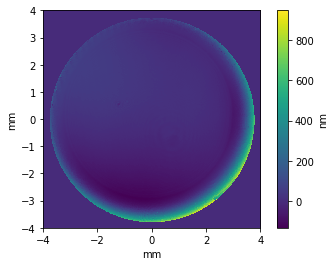

In [14]:
# setting up the xy axis values
half_edge = int(raw_surf.shape[0]/2)
axis_scale =  np.linspace(-half_edge,half_edge, half_edge*2) * pixscale
xy_max_int = np.floor(np.amax(axis_scale.value))
axis_extent = [-xy_max_int, xy_max_int,
               -xy_max_int, xy_max_int,]

# plot real quick
plt.figure(facecolor='white')
plt.imshow(surf.value, origin='lower',
           extent=axis_extent)
plt.colorbar().set_label((str(surf.unit)))
plt.xlabel(str(pixscale.unit))
plt.ylabel(str(pixscale.unit))

In [15]:
beam_diam = np.sum(mask[int(mask.shape[0]/2)]) * pixscale
beam_diam

<Quantity 8.51601385 mm>

For OAP3, the 80% clear aperture is supposed to be at 12.705mm. This is 67% of the clear aperture data. This is likely due to the 4D interferometer having beam diameter limitations (~9mm). (For context, the Zygo Verifire in XWCL can go to 4 inch diameter.)

Additionally, it looks like from `genraw`, the raw data was saved (not the processed data which removed Zernikes). So, we need to post-process out the first 6 Zernikes like with the measurements the manufacturer did.

In [24]:
# Post-processing Zernike removal
from model_kit import zernike as zern
import copy
#z_tot = 6
z_tot=10 #looks like a lot of coma

# convert surface data to phase
k_num = wavelen.to(surf.unit)/(2*np.pi*u.radian)
surf_phase = surf/k_num
# remove the Zernikes
z_map, z_weight = zern.calc_zernike_proj(data=surf_phase, 
                                         nterms=z_tot, 
                                         mask_full=mask)
surf_fix_phase = copy.copy(surf_phase)
for j in range(0, z_tot):
    surf_fix_phase = surf_fix_phase - (z_map[j]*z_weight[j])

# convert back to surface
surf_fix = surf_fix_phase*k_num

# zero mean
surf_mean = np.mean(surf_fix[mask==True])
surf_fix = surf_fix - surf_mean

Text(0, 0.5, 'mm')

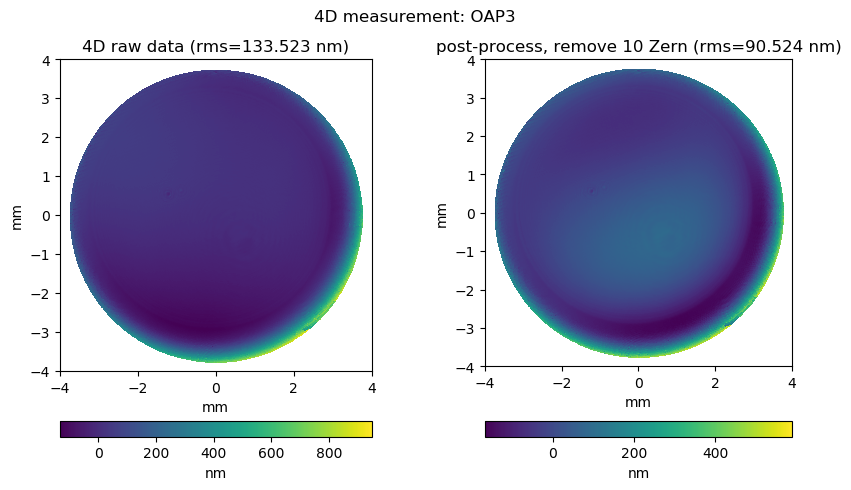

In [25]:
pre_surf = copy.copy(surf)
pre_surf[mask==0] = np.nan
pre_surf_rms = rms(pre_surf[mask==1])

post_surf = copy.copy(surf_fix)
post_surf[mask==0] = np.nan
post_surf_rms = rms(post_surf[mask==1])

xy_max_int = np.floor(np.amax(axis_scale.value))
axis_extent = [-xy_max_int, xy_max_int,
               -xy_max_int, xy_max_int]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100,
                              facecolor='white')
fig.suptitle('4D measurement: OAP3')
img1 = ax1.imshow(pre_surf.value, origin='bottom',
                  extent=axis_extent)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("bottom", size="5%", pad=0.5)
ax1.set_title('4D raw data (rms={0:.3f})'.format(pre_surf_rms))
fig.colorbar(img1, cax=cax1, orientation='horizontal').set_label(str(pre_surf.unit))
ax1.set_xlabel(str(pixscale.unit))
ax1.set_ylabel(str(pixscale.unit))

img2 = ax2.imshow(post_surf.value, origin='bottom',
                 extent=axis_extent)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("bottom", size="5%", pad=0.55)
ax2.set_title('post-process, remove 10 Zern (rms={0:.3f})'.format(post_surf_rms))
fig.colorbar(img2, cax=cax2, orientation='horizontal').set_label(str(post_surf.unit))
ax2.set_xlabel(str(pixscale.unit))
ax2.set_ylabel(str(pixscale.unit))